In [ ]:
# Stocks Symbol List Data Source: https://datahub.io/core/nyse-other-listings#python
# Stock Data Source: FinnHub

In [1]:
# packages
# data
import finnhub
from datapackage import Package

# scientific
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# utils
import time
import requests
import json


In [ ]:
################################################################################################

In [ ]:
# Gathering data from https://datahub.io/core/nyse-other-listings#python 
# -- on 01.12.2021 8497 symbols were captured
# stocks = []
# package = Package('https://datahub.io/core/nyse-other-listings/datapackage.json')

# # print list of all resources:
# # print(package.resource_names)

# # print processed tabular data (if exists any)
# for resource in package.resources:
#     if resource.descriptor['datahub']['type'] == 'derived/csv':
#         for entry in resource.read():
#             stocks.append(entry[0])

In [90]:
# EXTRA SYMBOLS
weed_stocks = ["GRWG", "JUSHF", "CRLBF", "HRVSF", "MJ", "CURLF", "CGC"]

tech_stocks = ["SNE", "XRX", "CSCO", "SIRI", "ROKU", "ATVI", "EA", "VZ", "T", "TMUS", "AMAT",
              "TXN", "MU", "FB", "MSFT", "SNAP", "AMZN", "TWTR", "AMD", "QCOM", "AVGO", "AAPL",
              "INTC", "NVDA", "NFLX"]

fin_stocks = ["AXP", "V", "MA", "JPM", "DFS", "MS", "BAC", "GS", "SQ", "PYPL", "GDOT"]

oil_chem_stocks = ["NGG", "PCG", "RDS-B", "OXY", "MRO", "DD", "CVX", "DOW", "XOM", "PSX", "COP", 
              "HAL"]

travel_stocks = ["LUV", "MAR", "ABNB", "CCL", "RCL", "DIS", "AAL", "JBLU", "SAVE", "DAL"]

food_consumer_stocks = ["DRI", "GIS", "NKE", "PG", "SHAK", "GRUB", "KDP", "PEP", "KO", "K", "QSR", "CMG",
              "YUM", "BGS", "ACI", "DAR", "KR", "GE", "GOOS", "HD", "LULU", "DPZ", "SBUX", "MMM",
              "WMT", "TGT", "COST", "JACK", "MCD"]

pharma_stocks = ["CVS", "RAD", "UNH", "LLY", "JNJ", "BMY", "AZN", "MRK", "ABBV", "GILD", "PFE"]

defense_infra_stocks = ["GD", "LMT", "NOC", "BA", "CAT", "WM"]

auto_stocks = ["HMC", "TM", "F", "TSLA", "GM"]

all_stocks = (weed_stocks + tech_stocks + fin_stocks + oil_chem_stocks 
                + travel_stocks + food_consumer_stocks + pharma_stocks 
                + defense_infra_stocks + auto_stocks)

# for symb in all_stocks:
#     if str(symb) not in stocks:
#         stocks.append(str(symb))

In [ ]:
# scrubbing data of symbols which contain bad_chars = ["$", ";", ":", "!", "*", "."]
# -- run until there is no more output
# bad_chars = ["$", ";", ":", "!", "*", "."]

# for s in stocks:
#     for char in bad_chars:
#         if char in str(s):
#             print(s)
#             stocks.remove(str(s))

In [91]:
display(len(all_stocks))

116

In [ ]:
################################################################################################

In [92]:
df = {}

In [94]:
# Adding company beta and 10_day_avg_volume values to a dataframe
count = 1

# Stock data
for stock in all_stocks:
# for stock in ["DIS"]:
    try:
        # request company's beta
        r = requests.get('https://finnhub.io/api/v1/stock/metric?symbol=' + str(stock) + '&metric=all&token=bvt5fmf48v6rku8bvmn0')
        metrics = r.json()["metric"]
        count += 1

        beta = metrics["beta"]
        vol = metrics["10DayAverageTradingVolume"]
        if beta == None or vol == None or (str(stock) in df.keys()):
            continue

        # fill dictionary
        if beta >= 1.0:
            df[str(stock)] = {"beta": beta, "volume_10_day": vol}

    except:
        display(r.json())
        display(stock)
        time.sleep(30)
        pass

In [95]:
# dataframe to store stock data
data = pd.DataFrame(df)
data = data.transpose()
display(data)

,beta,volume_10_day
GRWG,3.10514,2.72027
CURLF,1.56339,1.16486
CGC,2.32319,1.33443
XRX,1.89355,1.55710
SIRI,1.11245,21.74240
...,...,...
BA,1.61184,13.23443
F,1.23812,54.11365
TSLA,2.11745,42.20043
GM,1.40576,12.85623


In [96]:
data['c'] = ''
data['o'] = ''
data['adx'] = ''
data['signal'] = ''
data['trending'] = ''
data['shareOutstanding'] = ''

In [98]:
# adding trends, signals, and price levels
count = 1

# Stock data
# for stock in ["MA", "CURLF", "AXP", "COP", "HAL", "DAR", "GOOS"]:
for stock in data.index:
    try:
        # Aggregate Indicators -- (signal, adx, trending)
        r = requests.get('https://finnhub.io/api/v1/scan/technical-indicator?symbol=' + str(stock) + '&resolution=W&token=bvt5fmf48v6rku8bvmn0')
        metrics = r.json()
        count += 1

        signal = metrics["technicalAnalysis"]["signal"]
        adx = metrics["trend"]["adx"]
        trending = metrics["trend"]["trending"]

        # add to dataframe
        data.at[str(stock), 'adx'] = adx
        data.at[str(stock), 'signal'] = signal
        data.at[str(stock), 'trending'] = trending


        # company profile -- shareOutstanding 
        r = requests.get('https://finnhub.io/api/v1/stock/profile2?symbol=' + str(stock) + '&token=bvt5fmf48v6rku8bvmn0')
        shares = r.json()["shareOutstanding"]

        # add to dataframe
        data.at[str(stock), 'shareOutstanding'] = shares


        # open price and current price
        r = requests.get('https://finnhub.io/api/v1/quote?symbol=' + str(stock) + '&token=bvt5fmf48v6rku8bvmn0')
        metrics = r.json()

        # add to dataframe
        data.at[str(stock), 'o'] = metrics['o']
        data.at[str(stock), 'c'] = metrics['c']

        # News Sentiment
        r = requests.get('https://finnhub.io/api/v1/news-sentiment?symbol=' + str(stock) + '&token=bvt5fmf48v6rku8bvmn0')
        metrics = r.json()

        data.at[str(stock), 'bearish'] = metrics["sentiment"]["bearishPercent"]
        data.at[str(stock), 'bullish'] = metrics["sentiment"]["bullishPercent"]

    except:
        print(str(count) + '...' + str(stock))
        time.sleep(30)
        pass

7...DAR


In [102]:
data = data.sort_values(by=["signal", "trending", "shareOutstanding"], axis=0, ascending=False)
# data = data.drop("RDS-B", axis=0)
n = len(data)
step = 15

data_1 = data[:step]
data_2 = data[step:step*2]
data_3 = data[step*2:step*3]
data_4 = data[step*3:]

ls = [data_1, data_2, data_3, data_4]

for df in ls:
    display(df)

,beta,volume_10_day,c,o,adx,signal,trending,shareOutstanding,bearish,bullish
GE,1.07814,68.00689,11.78,11.51,38.3858,strong buy,True,8738.43,0.0000,1.0000
F,1.23812,54.11365,9.78,9.3,38.3588,strong buy,True,4082,0.4286,0.5714
JPM,1.20022,12.89788,140.22,139.44,28.6283,strong buy,True,3084.02,0.5000,0.5000
SNAP,1.29288,18.17058,56.45,55.22,54.7709,strong buy,True,1415.8,0.2000,0.8000
GM,1.40576,12.85623,47.82,46.3,38.4709,strong buy,True,1400,0.0000,1.0000
TXN,1.06505,3.30721,172.3,171.29,45.5824,strong buy,True,932.03,0.0000,1.0000
AMAT,1.47766,5.46986,100.01,98.53,36.0906,strong buy,True,914,0.0000,1.0000
DD,1.65519,10.68745,86.36,83.56,31.4498,strong buy,True,738.56,0.5000,0.5000
CURLF,1.56339,1.16486,14.16,15.03,32.8696,strong buy,True,470.09,0.0000,1.0000
CGC,2.32319,1.33443,30.92,31.5,38.9562,strong buy,True,350.11,0.0000,1.0000


,beta,volume_10_day,c,o,adx,signal,trending,shareOutstanding,bearish,bullish
GRWG,3.10514,2.72027,50.31,50.63,72.799,strong buy,True,36.88,0.0000,1.0000
BAC,1.55317,47.77609,33.66,33.42,24.3733,strong buy,False,8836.15,0.0000,1.0000
HAL,2.87481,9.06171,22.13,20.89,24.8765,strong buy,False,878,0.5000,0.5000
QSR,1.30033,0.51532,62.65,63.57,12.9048,strong buy,False,298.28,0.5000,0.5000
FB,1.25477,15.05396,251.09,256.63,35.0565,neutral,True,2852,0.6429,0.3571
SIRI,1.11245,21.74240,5.88,5.94,19.0058,neutral,False,4412,0.0000,1.0000
AAL,1.84665,57.59703,15.38,15.075,19.4106,neutral,False,428.2,0.6667,0.3333
LULU,1.34788,1.43233,356.93,361.6,19.3516,neutral,False,136.58,0.0000,1.0000
AAPL,1.26823,110.60446,128.8,128.5,27.4566,buy,True,16976.8,0.3590,0.6410
DIS,1.18498,8.75067,175.99,177.3,35.9621,buy,True,1781,0.1429,0.8571


,beta,volume_10_day,c,o,adx,signal,trending,shareOutstanding,bearish,bullish
TSLA,2.11745,42.20043,849.44,831,60.8842,buy,True,905,0.0639,0.9361
OXY,2.48238,20.90876,22.62,20.59,26.0951,buy,True,894.11,1.0000,0.0000
MRO,3.35023,27.54836,8.39,7.87,25.2378,buy,True,796,0.5000,0.5000
NVDA,1.41223,6.81981,539.39,550.1,45.5274,buy,True,613,0.0435,0.9565
LUV,1.19464,5.90607,48.13,47.7,29.5199,buy,True,519.06,0.0000,1.0000
AMZN,1.14864,3.52483,3120.83,3120,37.9337,buy,True,498,0.4681,0.5319
SQ,2.58161,10.74519,227.52,228.51,44.3238,buy,True,432.8,0.0000,1.0000
AVGO,1.04790,1.33379,449.39,447.77,38.6589,buy,True,407,0.0000,1.0000
MAR,1.83623,1.72539,127.39,127.89,25.9729,buy,True,324,0.0000,1.0000
DFS,1.76772,1.95352,95.33,95.67,46.0775,buy,True,310.16,0.5000,0.5000


,beta,volume_10_day,c,o,adx,signal,trending,shareOutstanding,bearish,bullish
COP,1.83489,7.84057,47.42,46.02,18.7325,buy,False,1084.87,0.5000,0.5000
HD,1.02799,3.03636,276.33,271.11,9.78138,buy,False,1077,0.0000,1.0000
MA,1.17003,3.14245,342.92,347.08,15.1137,buy,False,1007,0.0000,1.0000
AXP,1.26443,3.10162,121.62,122,19.4301,buy,False,810,0.5000,0.5000
CCL,2.29749,30.40539,20.13,20.05,20.2129,buy,False,684,1.0000,0.0000
DAL,1.42639,10.76854,40.3,39.69,21.6637,buy,False,642.77,0.3334,0.6666
BA,1.61184,13.23443,208.41,206.65,17.4431,buy,False,562.91,0.9500,0.0500
PCG,1.37001,10.95903,12.18,12.15,16.5589,buy,False,529.24,0.5000,0.5000
PSX,1.69529,2.91573,73.74,72.72,18.2875,buy,False,441.03,0.5000,0.5000
YUM,1.09412,1.48951,107.67,107.49,22.332,buy,False,300,0.5000,0.5000


In [88]:
for stock in data_1.index:
    tmp = {}
    series = data_1.loc[stock]
    tmp["Symb"] = stock
    tmp["Trending"] = str(series["trending"])
    tmp["Signal"] = str(series["signal"])
    tmp["shareOutstanding"] = str(series["shareOutstanding"])
    tmp["bearish"] = str(series["bearish"])
    tmp["bullish"] = str(series["bullish"])
    
    if tmp["Trending"] == 'True':
        display(tmp)

{'Symb': 'GE',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '8738.43',
 'bearish': '0.0',
 'bullish': '1.0'}

{'Symb': 'F',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '4082',
 'bearish': '0.4286',
 'bullish': '0.5714'}

{'Symb': 'JPM',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '3084.02',
 'bearish': '0.5',
 'bullish': '0.5'}

{'Symb': 'SNAP',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '1415.8',
 'bearish': '0.2',
 'bullish': '0.8'}

{'Symb': 'GM',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '1400',
 'bearish': '0.0',
 'bullish': '1.0'}

{'Symb': 'CVS',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '1302',
 'bearish': '0.0',
 'bullish': '1.0'}

{'Symb': 'AMAT',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '914',
 'bearish': '0.0',
 'bullish': '1.0'}

{'Symb': 'DD',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '738.56',
 'bearish': '0.5',
 'bullish': '0.5'}

{'Symb': 'CAT',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '550.08',
 'bearish': '0.0',
 'bullish': '1.0'}

{'Symb': 'TGT',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '504.2',
 'bearish': '0.0',
 'bullish': '1.0'}

{'Symb': 'CURLF',
 'Trending': 'True',
 'Signal': 'strong buy',
 'shareOutstanding': '470.09',
 'bearish': '0.0',
 'bullish': '1.0'}

In [57]:
# for DEV
# pattern recognition
# for stock in data_1.index:
#     r = requests.get('https://finnhub.io/api/v1/scan/pattern?symbol=' + str(stock) + '&resolution=D&token=bvt5fmf48v6rku8bvmn0')
#     points = r.json()["points"]
#     for entry in points:
#         display(entry)

{'aprice': 1173.1700439453,
 'atime': 1604275200,
 'bprice': 1344.2700195312,
 'btime': 1604880000,
 'cprice': 1222.2199707031,
 'ctime': 1604966400,
 'dprice': 0,
 'dtime': 0,
 'end_price': 1344.2700195312,
 'end_time': 1607299200,
 'entry': 1344.27001953,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 1515.36999512,
 'profit2': 0,
 'sortTime': 1607299200,
 'start_price': 1344.2700195312,
 'start_time': 1603411200,
 'status': 'complete',
 'stoploss': 1156.06004639,
 'symbol': 'CMG.US',
 'terminal': 0}

{'aprice': 1182.9899902344,
 'atime': 1600646400,
 'bprice': 1287.8399658203,
 'btime': 1600819200,
 'cprice': 1214,
 'ctime': 1601596800,
 'dprice': 0,
 'dtime': 0,
 'end_price': 1287.8399658203,
 'end_time': 1601942400,
 'entry': 1287.83996582,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 1392.68994141,
 'profit2': 0,
 'sortTime': 1601942400,
 'start_price': 1287.8399658203,
 'start_time': 1600128000,
 'status': 'successful',
 'stoploss': 1172.50499268,
 'symbol': 'CMG.US',
 'terminal': 0}

{'aprice': 35.621402189347634,
 'atime': 1607904000,
 'bprice': 31.298770825808226,
 'btime': 1607904000,
 'cprice': 44.19122703796177,
 'ctime': 1608768000,
 'dprice': 39.868595674422366,
 'dtime': 1608768000,
 'entry': 44.191227037962,
 'entry_date': 1588896000,
 'eprice': 17.950000762939,
 'etime': 1604361600,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 48.513858401501,
 'profit2': 61.86262846437,
 'sortTime': 1608768000,
 'status': 'failed',
 'stoploss': 39.868595674422,
 'symbol': 'GRWG.US',
 'terminal': 0}

{'aprice': 37.189998626709,
 'atime': 1606694400,
 'bprice': 32.229999542236,
 'btime': 1606780800,
 'cprice': 36.5,
 'ctime': 1607040000,
 'dprice': 0,
 'dtime': 0,
 'end_price': 32.229999542236,
 'end_time': 1607385600,
 'entry': 32.22999954,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Top',
 'patterntype': 'bearish',
 'profit1': 27.27000046,
 'profit2': 0,
 'sortTime': 1607385600,
 'start_price': 32.229999542236,
 'start_time': 1606262400,
 'status': 'failed',
 'stoploss': 37.68599854,
 'symbol': 'GRWG.US',
 'terminal': 0}

{'aprice': 17.889999389647997,
 'atime': 1597968000,
 'bprice': 14.45211327502134,
 'btime': 1597968000,
 'cprice': 15.201735526313197,
 'ctime': 1598918400,
 'dprice': 11.76384941168654,
 'dtime': 1598918400,
 'entry': 15.201735526313,
 'entry_date': 1599004800,
 'eprice': 6.8899998664856,
 'etime': 1594684800,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 18.63962164094,
 'profit2': 26.201735049476,
 'sortTime': 1598918400,
 'status': 'success',
 'stoploss': 11.763849411687,
 'symbol': 'GRWG.US',
 'terminal': 0}

{'aprice': 7.8213000297546,
 'atime': 1591660800,
 'dprice': 6.0100002288818,
 'dtime': 1592179200,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1592179200,
 'status': 'complete',
 'symbol': 'GRWG.US'}

{'aprice': 86.76000213623,
 'atime': 1604880000,
 'bprice': 74.309997558594,
 'btime': 1605139200,
 'cprice': 82.050003051758,
 'ctime': 1605657600,
 'dprice': 75.040901184082,
 'dtime': 1605830400,
 'entry': 79.43333689372,
 'entry_date': 1606176000,
 'intersect_price': 75.92710435274952,
 'intersect_time': 1606953600,
 'mature': 1,
 'patternname': 'Triangle',
 'patterntype': 'bullish',
 'profit1': 91.88334147135,
 'profit2': 0,
 'sortTime': 1605830400,
 'status': 'complete',
 'stoploss': 74.23568756104,
 'symbol': 'SHAK.US',
 'terminal': 0}

{'aprice': 70.900001525879,
 'atime': 1600300800,
 'bprice': 65.66413670972081,
 'btime': 1600300800,
 'cprice': 67.10552945054864,
 'ctime': 1601251200,
 'dprice': 61.869664634390446,
 'dtime': 1601251200,
 'entry': 67.10552945055,
 'entry_date': 1601337600,
 'eprice': 50.490001678467,
 'etime': 1597017600,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 72.34139426671,
 'profit2': 87.51552929796,
 'sortTime': 1601251200,
 'status': 'success',
 'stoploss': 61.86966463439,
 'symbol': 'SHAK.US',
 'terminal': 0}

{'aprice': 63.799999237061,
 'atime': 1591574400,
 'dprice': 52.279998779297,
 'dtime': 1591833600,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1591833600,
 'status': 'complete',
 'symbol': 'SHAK.US'}

{'aprice': 370.56500244141,
 'atime': 1604275200,
 'bprice': 402.32998657227,
 'btime': 1604620800,
 'cprice': 370,
 'ctime': 1604880000,
 'dprice': 0,
 'dtime': 0,
 'end_price': 402.32998657227,
 'end_time': 1608681600,
 'entry': 402.32998657,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 434.65997314,
 'profit2': 0,
 'sortTime': 1608681600,
 'start_price': 402.32998657227,
 'start_time': 1602806400,
 'status': 'complete',
 'stoploss': 366.76700134,
 'symbol': 'DPZ.US',
 'terminal': 0}

{'aprice': 376.11999511719,
 'atime': 1599523200,
 'bprice': 401.98110961914,
 'btime': 1599782400,
 'cprice': 385.98001098633,
 'ctime': 1600214400,
 'dprice': 0,
 'dtime': 0,
 'end_price': 401.98110961914,
 'end_time': 1600646400,
 'entry': 401.98110962,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 427.84222412,
 'profit2': 0,
 'sortTime': 1600646400,
 'start_price': 401.98110961914,
 'start_time': 1599091200,
 'status': 'successful',
 'stoploss': 373.53388367,
 'symbol': 'DPZ.US',
 'terminal': 0}

{'aprice': 64.970001220703,
 'atime': 1602547200,
 'bprice': 51.825000762939005,
 'btime': 1604016000,
 'cprice': 59.639999389648,
 'ctime': 1604880000,
 'dprice': 0,
 'dtime': 0,
 'end_price': 51.825000762939005,
 'end_time': 1605744000,
 'entry': 51.82500076,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Top',
 'patterntype': 'bearish',
 'profit1': 38.68000031,
 'profit2': 0,
 'sortTime': 1605744000,
 'start_price': 51.825000762939005,
 'start_time': 1601596800,
 'status': 'complete',
 'stoploss': 66.28450127,
 'symbol': 'GDOT.US',
 'terminal': 0}

{'aprice': 56.919998168945,
 'atime': 1596585600,
 'dprice': 50.060001373291,
 'dtime': 1597104000,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1597104000,
 'status': 'complete',
 'symbol': 'GDOT.US'}

{'aprice': 54.389999389648,
 'atime': 1595462400,
 'bprice': 50.48502673092419,
 'btime': 1595462400,
 'cprice': 53.81535630509701,
 'ctime': 1596067200,
 'dprice': 49.910383646373205,
 'dtime': 1596067200,
 'entry': 53.815356305097,
 'entry_date': 1596499200,
 'eprice': 37.479999542236,
 'etime': 1592265600,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 57.720328963821,
 'profit2': 70.725356152509,
 'sortTime': 1596067200,
 'status': 'failed',
 'stoploss': 49.910383646373,
 'symbol': 'GDOT.US',
 'terminal': 0}

{'aprice': 20.709999084473004,
 'atime': 1608249600,
 'bprice': 18.6149205680077,
 'btime': 1608249600,
 'cprice': 17.104531659530004,
 'ctime': 1609804800,
 'dprice': 15.009453143064697,
 'dtime': 1609804800,
 'entry': 17.10453165953,
 'entry_date': 1609891200,
 'eprice': 11.109999656677,
 'etime': 1606262400,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 19.199610175995,
 'profit2': 26.704531087326,
 'sortTime': 1609804800,
 'status': 'complete',
 'stoploss': 15.009453143065,
 'symbol': 'RAD.US',
 'terminal': 0}

{'aprice': 20.290000915527,
 'atime': 1607472000,
 'bprice': 17.069999694824,
 'btime': 1608076800,
 'cprice': 22.420000076294,
 'ctime': 1608163200,
 'dprice': 0,
 'dtime': 0,
 'end_price': 17.069999694824,
 'end_time': 1609113600,
 'entry': 17.06999969,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Top',
 'patterntype': 'bearish',
 'profit1': 11.71999931,
 'profit2': 0,
 'sortTime': 1609113600,
 'start_price': 17.069999694824,
 'start_time': 1607385600,
 'status': 'complete',
 'stoploss': 22.95500011,
 'symbol': 'RAD.US',
 'terminal': 0}

{'aprice': 13.140000343323,
 'atime': 1605484800,
 'dprice': 10.680000305176,
 'dtime': 1605744000,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1605744000,
 'status': 'complete',
 'symbol': 'RAD.US'}

{'aprice': 9.5699996948242,
 'atime': 1601942400,
 'bprice': 10.24965430005257,
 'btime': 1601942400,
 'cprice': 10.065518130304344,
 'ctime': 1602201600,
 'dprice': 10.745172735532716,
 'dtime': 1602201600,
 'entry': 10.065518130304,
 'entry_date': 1602460800,
 'eprice': 12.359999656677,
 'etime': 1600905600,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bearish',
 'profit1': 9.385863525076,
 'profit2': 7.275518168452,
 'sortTime': 1602201600,
 'status': 'success',
 'stoploss': 10.745172735533,
 'symbol': 'RAD.US',
 'terminal': 0}

{'aprice': 13.765000343323,
 'atime': 1600732800,
 'dprice': 9.7299995422363,
 'dtime': 1601251200,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1601251200,
 'status': 'complete',
 'symbol': 'RAD.US'}

{'aprice': 16.319999694824,
 'atime': 1597017600,
 'dprice': 14.529999732971,
 'dtime': 1597276800,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1597276800,
 'status': 'complete',
 'symbol': 'RAD.US'}

{'aprice': 18.610000610352,
 'atime': 1594166400,
 'bprice': 15.844346936655764,
 'btime': 1594166400,
 'cprice': 15.630001913997646,
 'ctime': 1597017600,
 'dprice': 12.864348240301407,
 'dtime': 1597017600,
 'entry': 15.630001913998,
 'entry_date': 1597104000,
 'eprice': 12.869999885559,
 'etime': 1592870400,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 18.395655587694,
 'profit2': 21.370002638791,
 'sortTime': 1597017600,
 'status': 'failed',
 'stoploss': 12.864348240301,
 'symbol': 'RAD.US',
 'terminal': 0}

{'aprice': 28.590000152588,
 'atime': 1601251200,
 'dprice': 26.739999771118,
 'dtime': 1601510400,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1601510400,
 'status': 'complete',
 'symbol': 'BGS.US'}

{'aprice': 27.466907423817982,
 'atime': 1607990400,
 'bprice': 25.287271306126435,
 'btime': 1607990400,
 'cprice': 25.439274066438077,
 'ctime': 1609113600,
 'dprice': 23.25963794874653,
 'dtime': 1609113600,
 'entry': 25.439274066438,
 'entry_date': 1609200000,
 'eprice': 16.959999084473,
 'etime': 1604016000,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 27.61891018413,
 'profit2': 35.946182405783,
 'sortTime': 1609113600,
 'status': 'complete',
 'stoploss': 23.259637948747,
 'symbol': 'SAVE.US',
 'terminal': 0}

{'aprice': 22.959999084473,
 'atime': 1604880000,
 'dprice': 17.979999542236,
 'dtime': 1605139200,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1605139200,
 'status': 'complete',
 'symbol': 'SAVE.US'}

{'aprice': 18.700000762939,
 'atime': 1603411200,
 'dprice': 15.449999809265,
 'dtime': 1603843200,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1603843200,
 'status': 'complete',
 'symbol': 'SAVE.US'}

{'aprice': 19.489999771118,
 'atime': 1594771200,
 'dprice': 16.610000610352,
 'dtime': 1595203200,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1595203200,
 'status': 'complete',
 'symbol': 'SAVE.US'}

{'aprice': 24.049999237061,
 'atime': 1591660800,
 'bprice': 16.987328893567817,
 'btime': 1591660800,
 'cprice': 20.831676526303962,
 'ctime': 1592265600,
 'dprice': 13.769006182810779,
 'dtime': 1592265600,
 'entry': 20.831676526304,
 'entry_date': 1592352000,
 'eprice': 12,
 'etime': 1590710400,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 27.894346869797,
 'profit2': 32.881675763365,
 'sortTime': 1592265600,
 'status': 'complete',
 'stoploss': 13.769006182811,
 'symbol': 'SAVE.US',
 'terminal': 0}

{'aprice': 62.10533332824733,
 'atime': 1592179200,
 'bprice': 70.61000442504951,
 'btime': 1592179200,
 'cprice': 73.81400680541901,
 'ctime': 1598486400,
 'dprice': 80.71285193306993,
 'dtime': 1598486400,
 'entry': 0,
 'entry_date': 0,
 'patternclass': 'chart',
 'patternname': 'channel',
 'patterntype': 'bullish',
 'profit1': 0,
 'profit2': 0,
 'sortTime': 1598486400,
 'status': 'complete',
 'stoploss': 0,
 'symbol': 'GRUB.US',
 'terminal': 0,
 'time': 1610409600}

{'aprice': 79.099998474121,
 'atime': 1597708800,
 'dprice': 74.419998168945,
 'dtime': 1598227200,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1598227200,
 'status': 'complete',
 'symbol': 'GRUB.US'}

{'aprice': 32.950000762939,
 'atime': 1606867200,
 'dprice': 31.709999084473,
 'dtime': 1607299200,
 'mature': 1,
 'patternname': 'three line strike',
 'patterntype': 'bullish',
 'sortTime': 1607299200,
 'status': 'complete',
 'symbol': 'GOOS.US'}

{'aprice': 36.869998931885,
 'atime': 1604880000,
 'bprice': 33.009998321533,
 'btime': 1605484800,
 'cprice': 39.310001373291,
 'ctime': 1606176000,
 'dprice': 0,
 'dtime': 0,
 'end_price': 33.009998321533,
 'end_time': 1606694400,
 'entry': 33.00999832,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Top',
 'patterntype': 'bearish',
 'profit1': 26.70999527,
 'profit2': 0,
 'sortTime': 1606694400,
 'start_price': 33.009998321533,
 'start_time': 1604620800,
 'status': 'complete',
 'stoploss': 39.94000168,
 'symbol': 'GOOS.US',
 'terminal': 0}

{'aprice': 39.310001373291,
 'atime': 1606176000,
 'dprice': 32.900001525879,
 'dtime': 1606694400,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1606694400,
 'status': 'complete',
 'symbol': 'GOOS.US'}

{'aprice': 36.59999847412101,
 'atime': 1603411200,
 'bprice': 33.837083133170104,
 'btime': 1603411200,
 'cprice': 32.27808208768287,
 'ctime': 1604361600,
 'dprice': 29.515166746731964,
 'dtime': 1604361600,
 'entry': 32.278082087683,
 'entry_date': 1604448000,
 'eprice': 22.959999084473,
 'etime': 1598227200,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 35.040997428634,
 'profit2': 45.918081477331,
 'sortTime': 1604361600,
 'status': 'success',
 'stoploss': 29.515166746732,
 'symbol': 'GOOS.US',
 'terminal': 0}

{'aprice': 23.420000076294,
 'atime': 1588896000,
 'dprice': 20.14999961853,
 'dtime': 1589328000,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1589328000,
 'status': 'complete',
 'symbol': 'GOOS.US'}

{'aprice': 363.44000244141,
 'atime': 1608768000,
 'bprice': 336.1827770911785,
 'btime': 1608768000,
 'cprice': 339.8206699319958,
 'ctime': 1609804800,
 'dprice': 312.56344458176426,
 'dtime': 1609804800,
 'entry': 339.820669932,
 'entry_date': 1609891200,
 'eprice': 233.36000061035,
 'etime': 1605571200,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 367.07789528223,
 'profit2': 469.90067176306,
 'sortTime': 1609804800,
 'status': 'success',
 'stoploss': 312.56344458176,
 'symbol': 'ROKU.US',
 'terminal': 0}

{'aprice': 233.02447779392153,
 'atime': 1602720000,
 'bprice': 219.52932653394748,
 'btime': 1602720000,
 'cprice': 210.4761791926309,
 'ctime': 1604361600,
 'dprice': 196.98102793265684,
 'dtime': 1604361600,
 'entry': 210.47617919263,
 'entry_date': 1604448000,
 'eprice': 163.72999572754,
 'etime': 1600646400,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 223.9713304526,
 'profit2': 279.77066125901,
 'sortTime': 1604361600,
 'status': 'success',
 'stoploss': 196.98102793266,
 'symbol': 'ROKU.US',
 'terminal': 0}

{'aprice': 125.55999755859,
 'atime': 1604880000,
 'bprice': 104.56999969482,
 'btime': 1605139200,
 'cprice': 114.34999847412,
 'ctime': 1606176000,
 'dprice': 105.59999847412,
 'dtime': 1606694400,
 'entry': 108.74499893189001,
 'entry_date': 1606953600,
 'intersect_price': 106.1004820562102,
 'intersect_time': 1607299200,
 'mature': 1,
 'patternname': 'Triangle',
 'patterntype': 'bullish',
 'profit1': 129.73499679566,
 'profit2': 0,
 'sortTime': 1606694400,
 'status': 'complete',
 'stoploss': 104.46542969513001,
 'symbol': 'DRI.US',
 'terminal': 0}

{'aprice': 104.61000061035001,
 'atime': 1601942400,
 'bprice': 100.69323859642994,
 'btime': 1601942400,
 'cprice': 98.60568573698477,
 'ctime': 1603324800,
 'dprice': 94.68892372306469,
 'dtime': 1603324800,
 'entry': 98.60568573698,
 'entry_date': 1603411200,
 'eprice': 75.540000915527,
 'etime': 1596758400,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 102.5224477509,
 'profit2': 127.67568543181,
 'sortTime': 1603324800,
 'status': 'failed',
 'stoploss': 94.68892372306,
 'symbol': 'DRI.US',
 'terminal': 0}

{'aprice': 92.069999694824,
 'atime': 1591315200,
 'dprice': 70.800003051758,
 'dtime': 1591833600,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1591833600,
 'status': 'complete',
 'symbol': 'DRI.US'}

{'aprice': 383.44000244141,
 'atime': 1606953600,
 'bprice': 337.2799987793,
 'btime': 1607904000,
 'cprice': 387.36999511719,
 'ctime': 1608163200,
 'dprice': 0,
 'dtime': 0,
 'end_price': 337.2799987793,
 'end_time': 1610409600,
 'entry': 337.27999878,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Top',
 'patterntype': 'bearish',
 'profit1': 287.19000244,
 'profit2': 0,
 'sortTime': 1610409600,
 'start_price': 337.2799987793,
 'start_time': 1605744000,
 'status': 'incomplete',
 'stoploss': 392.37899475,
 'symbol': 'LULU.US',
 'terminal': 0}

{'aprice': 337.2799987793,
 'atime': 1607904000,
 'bprice': 387.36999511719,
 'btime': 1608163200,
 'cprice': 343.67001342773,
 'ctime': 1609200000,
 'dprice': 374.14999389648,
 'dtime': 1609977600,
 'entry': 372.11614755483004,
 'entry_date': 1610323200,
 'intersect_price': 357.7863832426152,
 'intersect_time': 1611446400,
 'mature': 1,
 'patternname': 'Triangle',
 'patterntype': 'bullish',
 'profit1': 422.20614389272,
 'profit2': 0,
 'sortTime': 1609977600,
 'status': 'complete',
 'stoploss': 336.94271878052,
 'symbol': 'LULU.US',
 'terminal': 1}

{'aprice': 399.88000488281,
 'atime': 1599004800,
 'dprice': 315.39999389648,
 'dtime': 1599609600,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1599609600,
 'status': 'complete',
 'symbol': 'LULU.US'}

{'aprice': 46.45999908447299,
 'atime': 1603411200,
 'bprice': 43.57454537374953,
 'btime': 1603411200,
 'cprice': 44.36681927463483,
 'ctime': 1604016000,
 'dprice': 41.48136556391136,
 'dtime': 1604016000,
 'entry': 44.3668192746348,
 'entry_date': 1604275200,
 'eprice': 33.830001831055,
 'etime': 1601251200,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 47.2522729853583,
 'profit2': 56.9968165280528,
 'sortTime': 1604016000,
 'status': 'success',
 'stoploss': 41.4813655639114,
 'symbol': 'DAR.US',
 'terminal': 0}

{'aprice': 285.13000488281,
 'atime': 1604016000,
 'bprice': 323.92001342773,
 'btime': 1604448000,
 'cprice': 292.76000976562,
 'ctime': 1608508800,
 'dprice': 305.51000976562,
 'dtime': 1609286400,
 'entry': 294.50401088169,
 'entry_date': 1609718400,
 'intersect_price': 297.618829134784,
 'intersect_time': 1611014400,
 'mature': 1,
 'patternname': 'Triangle',
 'patterntype': 'bearish',
 'profit1': 255.71400233677,
 'profit2': 0,
 'sortTime': 1609286400,
 'status': 'complete',
 'stoploss': 324.24393344116004,
 'symbol': 'NOC.US',
 'terminal': 0}

{'aprice': 294.04000854492,
 'atime': 1593043200,
 'bprice': 313.5,
 'btime': 1593993600,
 'cprice': 285.57998657227,
 'ctime': 1594252800,
 'dprice': 0,
 'dtime': 0,
 'end_price': 313.5,
 'end_time': 1595376000,
 'entry': 313.5,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 341.42001343,
 'profit2': 0,
 'sortTime': 1595376000,
 'start_price': 313.5,
 'start_time': 1592870400,
 'status': 'successful',
 'stoploss': 282.78798523,
 'symbol': 'NOC.US',
 'terminal': 0}

{'aprice': 313.5,
 'atime': 1593993600,
 'dprice': 285.57998657227,
 'dtime': 1594252800,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1594252800,
 'status': 'complete',
 'symbol': 'NOC.US'}

{'aprice': 343.48999023438,
 'atime': 1590537600,
 'dprice': 325.10000610352,
 'dtime': 1591056000,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1591056000,
 'status': 'complete',
 'symbol': 'NOC.US'}

{'aprice': 348.7799987793,
 'atime': 1590624000,
 'dprice': 325.10000610352,
 'dtime': 1591056000,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1591056000,
 'status': 'complete',
 'symbol': 'NOC.US'}

{'aprice': 84.97000122070298,
 'atime': 1607472000,
 'bprice': 79.64234317004421,
 'btime': 1607472000,
 'cprice': 72.66739735934718,
 'ctime': 1608681600,
 'dprice': 67.33973930868841,
 'dtime': 1608681600,
 'entry': 72.667397359347,
 'entry_date': 1608768000,
 'eprice': 56.380001068115,
 'etime': 1604361600,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 77.995055410006,
 'profit2': 101.257397511935,
 'sortTime': 1608681600,
 'status': 'complete',
 'stoploss': 67.339739308688,
 'symbol': 'RCL.US',
 'terminal': 0}

{'aprice': 72.110000610352,
 'atime': 1602201600,
 'dprice': 57.860000610352,
 'dtime': 1602720000,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1602720000,
 'status': 'complete',
 'symbol': 'RCL.US'}

{'aprice': 74.85206869178074,
 'atime': 1599609600,
 'bprice': 65.97654938165807,
 'btime': 1599609600,
 'cprice': 66.33138177397318,
 'ctime': 1600819200,
 'dprice': 57.4558624638505,
 'dtime': 1600819200,
 'entry': 66.331381773973,
 'entry_date': 1600905600,
 'eprice': 48.389999389648,
 'etime': 1596585600,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 75.206901084096,
 'profit2': 92.793451076106,
 'sortTime': 1600819200,
 'status': 'failed',
 'stoploss': 57.45586246385,
 'symbol': 'RCL.US',
 'terminal': 0}

{'aprice': 45.169998168945,
 'atime': 1593388800,
 'bprice': 58.650001525879,
 'btime': 1594771200,
 'cprice': 45.709999084473,
 'ctime': 1596412800,
 'dprice': 0,
 'dtime': 0,
 'end_price': 58.650001525879,
 'end_time': 1597104000,
 'entry': 58.65000153,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 72.13000488,
 'profit2': 0,
 'sortTime': 1597104000,
 'start_price': 58.650001525879,
 'start_time': 1592524800,
 'status': 'successful',
 'stoploss': 43.82199783,
 'symbol': 'RCL.US',
 'terminal': 0}

{'aprice': 75.550003051758,
 'atime': 1591574400,
 'bprice': 54.069999694824,
 'btime': 1591833600,
 'cprice': 66.889999389648,
 'ctime': 1592265600,
 'dprice': 0,
 'dtime': 0,
 'end_price': 54.069999694824,
 'end_time': 1592784000,
 'entry': 54.06999969,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Top',
 'patterntype': 'bearish',
 'profit1': 32.58999634,
 'profit2': 0,
 'sortTime': 1592784000,
 'start_price': 54.069999694824,
 'start_time': 1590969600,
 'status': 'failed',
 'stoploss': 77.69800339,
 'symbol': 'RCL.US',
 'terminal': 0}

{'aprice': 67.83999633789098,
 'atime': 1591747200,
 'bprice': 56.547757288942,
 'btime': 1591747200,
 'cprice': 60.40672355553694,
 'ctime': 1592179200,
 'dprice': 49.114484506587964,
 'dtime': 1592179200,
 'entry': 60.406723555537,
 'entry_date': 1592265600,
 'eprice': 49.090599060059,
 'etime': 1590710400,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bullish',
 'profit1': 71.698962604486,
 'profit2': 79.156120833369,
 'sortTime': 1592179200,
 'status': 'failed',
 'stoploss': 49.114484506588,
 'symbol': 'RCL.US',
 'terminal': 0}

{'aprice': 41.389999389648,
 'atime': 1588896000,
 'dprice': 33.409999847412,
 'dtime': 1589328000,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1589328000,
 'status': 'complete',
 'symbol': 'RCL.US'}

{'aprice': 24.209999084473,
 'atime': 1608076800,
 'bprice': 22.040000915527,
 'btime': 1608508800,
 'cprice': 23.700000762939,
 'ctime': 1609113600,
 'dprice': 22.260000228882,
 'dtime': 1609718400,
 'entry': 23.26285934448,
 'entry_date': 1609891200,
 'intersect_price': 22.574733772973254,
 'intersect_time': 1610755200,
 'mature': 1,
 'patternname': 'Triangle',
 'patterntype': 'bullish',
 'profit1': 25.43285751343,
 'profit2': 0,
 'sortTime': 1609718400,
 'status': 'complete',
 'stoploss': 22.01796091461,
 'symbol': 'XRX.US',
 'terminal': 0}

{'aprice': 14.510000228882,
 'atime': 1594252800,
 'bprice': 17.610000610352,
 'btime': 1594944000,
 'cprice': 14.819999694824,
 'ctime': 1595980800,
 'dprice': 0,
 'dtime': 0,
 'end_price': 17.610000610352,
 'end_time': 1597017600,
 'entry': 17.61000061,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 20.71000099,
 'profit2': 0,
 'sortTime': 1597017600,
 'start_price': 17.610000610352,
 'start_time': 1592265600,
 'status': 'successful',
 'stoploss': 14.20000019,
 'symbol': 'XRX.US',
 'terminal': 0}

{'aprice': 20.209999084473,
 'atime': 1591574400,
 'dprice': 16.020000457764,
 'dtime': 1591833600,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1591833600,
 'status': 'complete',
 'symbol': 'XRX.US'}

{'aprice': 416,
 'atime': 1591315200,
 'dprice': 383.79000854492,
 'dtime': 1591833600,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1591833600,
 'status': 'complete',
 'symbol': 'LMT.US'}

{'aprice': 417.58999633789,
 'atime': 1591574400,
 'dprice': 383.79000854492,
 'dtime': 1591833600,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1591833600,
 'status': 'complete',
 'symbol': 'LMT.US'}

{'aprice': 397.11999511719,
 'atime': 1590537600,
 'dprice': 384.76998901367,
 'dtime': 1590710400,
 'mature': 1,
 'patternname': 'evening star',
 'patterntype': 'bearish',
 'sortTime': 1590710400,
 'status': 'complete',
 'symbol': 'LMT.US'}

{'aprice': 16.14999961853,
 'atime': 1606176000,
 'bprice': 14.260000228882,
 'btime': 1606867200,
 'cprice': 16.35000038147,
 'ctime': 1607040000,
 'dprice': 0,
 'dtime': 0,
 'end_price': 14.260000228882,
 'end_time': 1607990400,
 'entry': 14.26000023,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Top',
 'patterntype': 'bearish',
 'profit1': 12.17000008,
 'profit2': 0,
 'sortTime': 1607990400,
 'start_price': 14.260000228882,
 'start_time': 1605571200,
 'status': 'complete',
 'stoploss': 16.5590004,
 'symbol': 'JBLU.US',
 'terminal': 0}

{'aprice': 10.960000038147,
 'atime': 1603929600,
 'bprice': 16.14999961853,
 'btime': 1606176000,
 'cprice': 14.260000228882,
 'ctime': 1606867200,
 'dprice': 16.35000038147,
 'dtime': 1607040000,
 'entry': 15.26434811302,
 'entry_date': 1607644800,
 'intersect_price': 16.798326842724947,
 'intersect_time': 1609113600,
 'mature': 1,
 'patternname': 'Wedge',
 'patterntype': 'bearish',
 'profit1': 10.07434853264,
 'profit2': 0,
 'sortTime': 1607040000,
 'status': 'complete',
 'stoploss': 16.36635038185,
 'symbol': 'JBLU.US',
 'terminal': 0}

{'aprice': 13.539999961853,
 'atime': 1603411200,
 'dprice': 11.109999656677,
 'dtime': 1603843200,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1603843200,
 'status': 'complete',
 'symbol': 'JBLU.US'}

{'aprice': 10.010000228882,
 'atime': 1594684800,
 'bprice': 11.312253779861477,
 'btime': 1594684800,
 'cprice': 10.485493050629044,
 'ctime': 1594857600,
 'dprice': 11.787746601608522,
 'dtime': 1594857600,
 'entry': 10.485493050629,
 'entry_date': 1595203200,
 'eprice': 13.449999809265,
 'etime': 1591747200,
 'mature': 1,
 'patternname': 'Flag',
 'patterntype': 'bearish',
 'profit1': 9.18323949965,
 'profit2': 7.045493470246,
 'sortTime': 1594857600,
 'status': 'failed',
 'stoploss': 11.787746601609,
 'symbol': 'JBLU.US',
 'terminal': 0}

{'aprice': 117.79000091553,
 'atime': 1604275200,
 'bprice': 128.88000488281,
 'btime': 1604534400,
 'cprice': 110.20999908447,
 'ctime': 1604880000,
 'dprice': 0,
 'dtime': 0,
 'end_price': 128.88000488281,
 'end_time': 1606867200,
 'entry': 128.88000488,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 147.55001068,
 'profit2': 0,
 'sortTime': 1606867200,
 'start_price': 128.88000488281,
 'start_time': 1603238400,
 'status': 'complete',
 'stoploss': 108.3429985,
 'symbol': 'EA.US',
 'terminal': 0}

{'aprice': 142.30999755859,
 'atime': 1595203200,
 'bprice': 132.7200012207,
 'btime': 1595548800,
 'cprice': 147.35000610352,
 'ctime': 1596672000,
 'dprice': 0,
 'dtime': 0,
 'end_price': 132.7200012207,
 'end_time': 1599091200,
 'entry': 132.72000122,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Top',
 'patterntype': 'bearish',
 'profit1': 118.08999634,
 'profit2': 0,
 'sortTime': 1599091200,
 'start_price': 132.7200012207,
 'start_time': 1593561600,
 'status': 'successful',
 'stoploss': 148.81300659,
 'symbol': 'EA.US',
 'terminal': 0}

{'aprice': 161.36999511719,
 'atime': 1592524800,
 'dprice': 146,
 'dtime': 1592956800,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1592956800,
 'status': 'complete',
 'symbol': 'GD.US'}

{'aprice': 58.650001525879,
 'atime': 1596585600,
 'dprice': 53.549999237061,
 'dtime': 1597017600,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1597017600,
 'status': 'complete',
 'symbol': 'QSR.US'}

{'aprice': 52.169998168945,
 'atime': 1593129600,
 'bprice': 56.740001678467,
 'btime': 1593993600,
 'cprice': 53.619998931885,
 'ctime': 1594684800,
 'dprice': 0,
 'dtime': 0,
 'end_price': 56.740001678467,
 'end_time': 1594771200,
 'entry': 56.74000168,
 'eprice': 0,
 'etime': 0,
 'mature': 0,
 'patternname': 'Double Bottom',
 'patterntype': 'bullish',
 'profit1': 61.31000519,
 'profit2': 0,
 'sortTime': 1594771200,
 'start_price': 56.740001678467,
 'start_time': 1592524800,
 'status': 'failed',
 'stoploss': 51.71299782,
 'symbol': 'QSR.US',
 'terminal': 0}

{'aprice': 110.55999755859,
 'atime': 1609200000,
 'dprice': 105.23999786377,
 'dtime': 1609804800,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1609804800,
 'status': 'complete',
 'symbol': 'YUM.US'}

{'aprice': 107.69999694824,
 'atime': 1606435200,
 'dprice': 104.80000305176,
 'dtime': 1606867200,
 'mature': 1,
 'patternname': 'two black gapping',
 'patterntype': 'bearish',
 'sortTime': 1606867200,
 'status': 'complete',
 'symbol': 'YUM.US'}

{'aprice': 98.650001525879,
 'atime': 1599004800,
 'dprice': 93.480003356934,
 'dtime': 1599523200,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1599523200,
 'status': 'complete',
 'symbol': 'YUM.US'}

{'aprice': 42.849998474121,
 'atime': 1588896000,
 'dprice': 35.75,
 'dtime': 1589328000,
 'mature': 1,
 'patternname': 'three black crows',
 'patterntype': 'bearish',
 'sortTime': 1589328000,
 'status': 'complete',
 'symbol': 'DFS.US'}

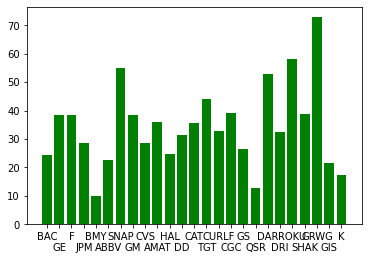

In [83]:
# plot for adx
fig, ax = plt.subplots()
ax.bar(data_1.index, data_1["adx"], color='g')

ax.set_xticks(range(len(data_1.index)))
ax.set_xticklabels(data_1.index)
# [1::2] means start from the second element in the list and get every other element
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.show()

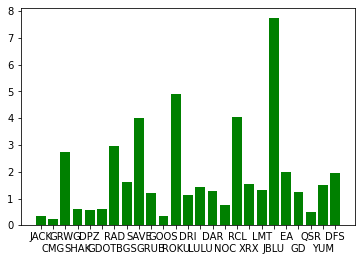

In [76]:
# plot for adx
fig, ax = plt.subplots()
ax.bar(data_1.index, data_1["volume_10_day"], color='g')

ax.set_xticks(range(len(data_1.index)))
ax.set_xticklabels(data_1.index)
# [1::2] means start from the second element in the list and get every other element
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.show()

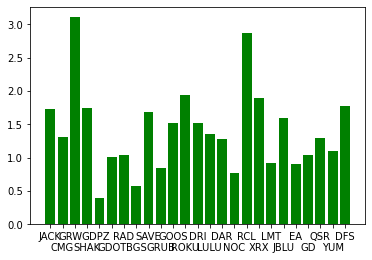

In [77]:
# plot for adx
fig, ax = plt.subplots()
ax.bar(data_1.index, data_1["beta"], color='g')

ax.set_xticks(range(len(data_1.index)))
ax.set_xticklabels(data_1.index)
# [1::2] means start from the second element in the list and get every other element
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.show()

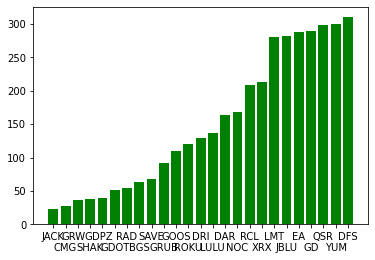

In [78]:
# plot for adx
fig, ax = plt.subplots()
ax.bar(data_1.index, data_1["shareOutstanding"], color='g')

ax.set_xticks(range(len(data_1.index)))
ax.set_xticklabels(data_1.index)
# [1::2] means start from the second element in the list and get every other element
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.show()